# Chapter 2. Bandit Problems
In this tutorial, we cover n-Armed Bandit Problem, following Chapter 2 of
`Reinforcement Learning: An Introduction` to study fundamental properties
of reinforcement learning, such as evaluative feedback and explotation vs
exprolitation.

### Definition of Bandit Problems

The following is the definicion/explanation of bandit problem from the book.

---

*You are faced repeatedly with a choice among n different options, or *
*actions. After each choice you receive a numerical reward chosen from a *
*stationary probability distribution that depends on the action you *
*selected. Your objective is to maximize the expected total reward over *
*some time period, for example, over 1000 action selections, or time steps.*

*This is the original form of the n-armed bandit problem, so named by *
*analogy to a slot machine, or "one-armed bandit," except that it has n *
*levers instead of one. Each action selection is like a play of one of *
*the slot machine's levers, and the rewards are the payoffs for hitting *
*the jackpot. Through repeated action selections you are to maximize *
*your winnings by concentrating your actions on the best levers.*

---

To summarize:
- You have a set of possible actions.
- At each time setp, you take action, you receive reward.
- You can take an action for a certain number of times.
- Your objective is to maximize *the sum of all rewards* you receive
through all the trial.
- Rewards are drawn from distributions correspond to taken actions.
- The reward distributions are fixed, thus any action taken at any
time do not have any effect on future rewards.
- You do not know the reward distributions beforehand.

You can create bandit problem using by subclassing luchador base environment
class, as follow.

In [1]:
# pylint: disable=invalid-name,attribute-defined-outside-init
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

import luchador.env
import luchador.agent

import ch_02_bandit_problem_util as util


class Bandit(luchador.env.BaseEnvironment):
    """N-armed bandit problem

    Parameters
    ----------
    n_arms : int
        The number of arms of bandit
    """
    def __init__(self, n_arms, seed=None):
        self.n_arms = n_arms
        self.rng = np.random.RandomState(seed=seed)

    @property
    def n_actions(self):
        return self.n_arms

    def reset(self):
        """Set distribution mean randomly"""
        self.mean = [self.rng.randn() for _ in range(self.n_arms)]
        self.stddev = [1 for _ in range(self.n_arms)]
        return luchador.env.Outcome(
            reward=0, observation=None, terminal=False)

    def step(self, n):
        """Sample reward from the given distribution"""
        reward = self.rng.normal(loc=self.mean[n], scale=self.stddev[n])
        return luchador.env.Outcome(
            reward=reward, observation=None, terminal=False)

    def __str__(self):
        return '\n'.join(
            'Acttion {:3d}: Mean {:5.2f}, Stddev {:5.2f}'.format(
                i, self.mean[i], self.stddev[i]) for i in range(self.n_arms)
        )

You need to initialize reward distribution as follow.

In [2]:
bandit = Bandit(n_arms=10, seed=10)
# `reset` generates rewards distributions with means randomly drawn
# from normal distribution and variance=1
bandit.reset()

You can peak in the resulting distributions as following.
This is not know to agent

In [3]:
print(bandit)

Acttion   0: Mean  1.33, Stddev  1.00
Acttion   1: Mean  0.72, Stddev  1.00
Acttion   2: Mean -1.55, Stddev  1.00
Acttion   3: Mean -0.01, Stddev  1.00
Acttion   4: Mean  0.62, Stddev  1.00
Acttion   5: Mean -0.72, Stddev  1.00
Acttion   6: Mean  0.27, Stddev  1.00
Acttion   7: Mean  0.11, Stddev  1.00
Acttion   8: Mean  0.00, Stddev  1.00
Acttion   9: Mean -0.17, Stddev  1.00


The mean values shown above are called `value` of each action. If agents
knew these values, then they could solve bandit problem just by selecting
the action with the highest value. Agents, however can only estimate these
value.

### Exploitation, Exploration and Greedy Action

Let's estimate action values by taking average rewards.

In [4]:
# We take each action 3 times just to have estimates for all actions for
# illustration purpose.
n_trials = 3
print('Hypothetical Estimation:')
for i in range(bandit.n_actions):
    value = sum([bandit.step(n=i).reward for _ in range(n_trials)]) / n_trials
    print('Action {}: {:7.3f}'.format(i, value))

Hypothetical Estimation:
Action 0:   1.555
Action 1:   1.283
Action 2:  -1.384
Action 3:  -1.609
Action 4:   1.880
Action 5:   0.337
Action 6:   0.290
Action 7:  -0.189
Action 8:   0.639
Action 9:  -0.112


We know that these estimates are not accurate, but agent does not know
the true action values. The action with the highest estimated value is called
*greedy action*. When making decision on which action to take next,
agent can eiether repeat the greedy action to maximize total rewards, or
try other actions. The former is called *exploitation*, and the latter
is called *exploration*. Since exploitation and exploration cannot be carried
out at the same time, agents have way to balance actions between them.

### Action-value method and epsilon-greedy policy

Let's incorperate some action selection into simple average action value
gestimation.

We consider the following rules.
1. Select the actions with highest estimated action values at the time being.
2. Behave like 1 most of the time, but every once in a while, select action
randomly with equal probability.

Rule 2. is called epsilon-greedy method, where epsilon represents the
probability of taking random action. Rule 1. is called greedy method but can
be considered as a special case of epsilon-greedy method, that is epsilon=0.

To see the different behavior of these rules, let's run an experiment.
In this experiment, we run 2000 independant 10-armed bandit problem.

Agents estimate action values by tracking average rewards for each action
and select the next action based on epsilon-greedy method.
Such agent can be implemented as following, using base luchador agent class.

In [5]:
class EGreedyAgent(luchador.agent.BaseAgent):
    """Simple E-Greedy policy for stationary environment

    Parameters
    ----------
    epsolon : float
        The probability to take random action.

    step_size : 'average' or float
        Parameter to adjust how action value is estimated from the series of
        observations. When 'average', estimated action value is simply the mean
        of all the observed rewards for the action. When float, estimation is
        updated with weighted sum over current estimation and newly observed
        reward value.

    initial_q : float
        Initial Q value for all actions

    seed : int
        Random seed
    """
    def __init__(self, epsilon, step_size='average', initial_q=0.0, seed=None):
        self.epsilon = epsilon
        self.step_size = step_size
        self.initial_q = initial_q
        self.rng = np.random.RandomState(seed=seed)

    def reset(self, observation):
        self.q_values = [self.initial_q] * self.n_actions
        self.n_trials = [self.initial_q] * self.n_actions

    def init(self, environment):
        self.n_actions = environment.n_actions

    def observe(self, action, outcome):
        """Update the action value estimation based on observed outcome"""
        r, n, q = outcome.reward, self.n_trials[action], self.q_values[action]
        alpha = 1 / (n + 1) if self.step_size == 'average' else self.step_size
        self.q_values[action] += (r - q) * alpha
        self.n_trials[action] += 1

    def act(self, _=None):
        """Choose action based on e-greedy policy"""
        if self.rng.rand() < self.epsilon:
            return self.rng.randint(self.n_actions)
        else:
            return np.argmax(self.q_values)

Running epsilon = 0.0...
Running epsilon = 0.01...
Running epsilon = 0.1...


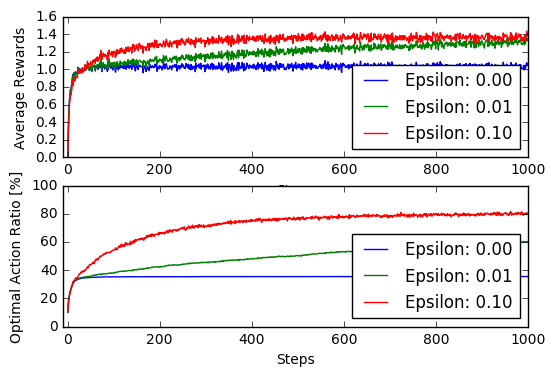

In [6]:
# Run 10-armed test bed for with different epsilon-greedy method
# and plot rewards and #optimal actions taken.

epsilons = [0.0, 0.01, 0.1]
mean_rewards, optimal_actions = [], []
for eps in epsilons:
    print('Running epsilon = {}...'.format(eps))
    env = Bandit(n_arms=10, seed=0)
    agent = EGreedyAgent(epsilon=eps)
    agent.init(env)
    rewards, actions = util.run_episodes(env, agent, episodes=2000, steps=1000)
    mean_rewards.append(rewards)
    optimal_actions.append(actions)

util.plot_result(epsilons, mean_rewards, optimal_actions)
plt.show()

### Imcremental Implementation
$$ Q_t(a) = \frac{R_1 +R_2 + \dots +R_{K_a}}{K_a}$$